<a href="https://colab.research.google.com/github/PioDru/colab/blob/main/chest_xray_pneumonia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#import kagglehub

# Download latest version
#path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

#print("Path to dataset files:", path)

100%|██████████| 2.29G/2.29G [00:24<00:00, 102MB/s] 

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2


In [1]:
#!/bin/bash
!curl -L -o ./chest-xray-pneumonia.zip https://www.kaggle.com/api/v1/datasets/download/paultimothymooney/chest-xray-pneumonia

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 2349M  100 2349M    0     0   197M      0  0:00:11  0:00:11 --:--:--  247M


In [2]:
!unzip -q ./chest-xray-pneumonia.zip  -d chest-xray-pneumonia

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Ustawienia ścieżek do danych – upewnij się, że struktura katalogów jest następująca:
# dataset/
# ├── train/
# │   ├── NORMAL/
# │   └── PNEUMONIA/
# ├── validation/
# │   ├── NORMAL/
# │   └── PNEUMONIA/
# └── test/
#     ├── NORMAL/
#     └── PNEUMONIA/
base_dir = '/content/chest-xray-pneumonia/chest_xray'  # np. './chest_xray'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Parametry przetwarzania obrazów
img_width, img_height = 150, 150  # rozmiar wejściowy obrazu
batch_size = 32

# Przygotowanie generatorów danych z augmentacją dla treningu
train_datagen = ImageDataGenerator(
    rescale=1./255,          # normalizacja pikseli
    rotation_range=20,       # losowe obroty
    width_shift_range=0.2,   # przesunięcia w poziomie
    height_shift_range=0.2,  # przesunięcia w pionie
    shear_range=0.2,         # transformacja skośna
    zoom_range=0.2,          # powiększenia
    horizontal_flip=True,    # odbicie lustrzane
    fill_mode='nearest'
)

# Dla zbiorów walidacyjnego i testowego używamy tylko skalowania
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Generatory danych
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary'
)

# Budowa modelu CNN
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # klasyfikacja binarna
])

early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor
    patience=4,          # Number of epochs to wait before stopping
    restore_best_weights=True  # Restore the best model weights
)

model_checkpoint = ModelCheckpoint(
    filepath='best_model.keras',  # Use .keras extension
    monitor='val_accuracy',       # Metric to monitor
    save_best_only=True,          # Save only the best model
    mode='max'                    # Maximize the monitored metric
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Metric to monitor
    factor=0.1,          # Reduce learning rate by a factor of 0.1
    patience=3           # Number of epochs to wait before reducing LR
)

# Kompilacja modelu
model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),
    metrics=['accuracy']
)

# Wyświetlenie podsumowania modelu
model.summary()

# Trening modelu
epochs = 20
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=[early_stopping, model_checkpoint, reduce_lr]  # Add callbacks here
)

# Ewaluacja na zbiorze testowym
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print('Dokładność na zbiorze testowym:', test_accuracy)

# Zapisanie modelu do pliku
model.save('pneumonia_classification_model.keras')
pretrained_model = tf.keras.applications.MobileNet()
tf.saved_model.save(pretrained_model, 'pneumonia_classification_model/mobilenet/1/')

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 15, 15, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       3,211,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,453,121 (13.17 MB)

 Trainable params: 3,453,121 (13.17 MB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 75s 424ms/step - accuracy: 0.7261 - loss: 0.5859 - val_accuracy: 0.5625 - val_loss: 0.8136 - learning_rate: 1.0000e-04
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 74s 403ms/step - accuracy: 0.7546 - loss: 0.5056 - val_accuracy: 0.6250 - val_loss: 0.5839 - learning_rate: 1.0000e-04
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 82s 406ms/step - accuracy: 0.8015 - loss: 0.4370 - val_accuracy: 0.6250 - val_loss: 1.0274 - learning_rate: 1.0000e-04
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 82s 404ms/step - accuracy: 0.8162 - loss: 0.3996 - val_accuracy: 0.6250 - val_loss: 0.9344 - learning_rate: 1.0000e-04
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 66s 402ms/step - accuracy: 0.8210 - loss: 0.3789 - val_accuracy: 0.6250 - val_loss: 0.6593 - learning_rate: 1.0000e-04
Epoch 6/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 66s 402ms/step - accuracy: 0.8593 - loss: 0.3121 - val_accuracy: 0.6250 - val_loss: 0.6409 - learning_rate: 1.0000e-05
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 225ms/step - acc

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 793ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
[[0.6188903]]
0.6188903
Predykcja (prawdopodobieństwo Pneumonii): 0.6188903
Wynik: Pneumonia


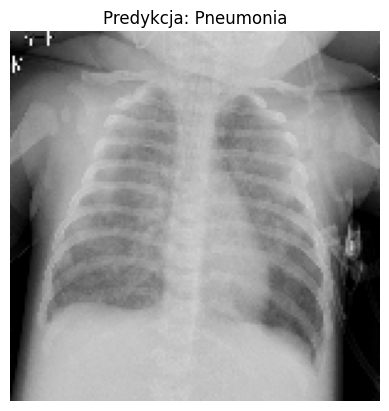

In [4]:
import keras
from keras import ops
from keras import utils
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Ścieżka do wybranego obrazu z zestawu danych
sample_image_path = '/content/chest-xray-pneumonia/chest_xray/val/PNEUMONIA/person1952_bacteria_4883.jpeg'  # zamień na faktyczną ścieżkę

# Wczytanie obrazu i przeskalowanie do wymiarów modelu
sample_img = keras.utils.load_img(sample_image_path, target_size=(img_width, img_height))
sample_img_array = keras.utils.img_to_array(sample_img)
sample_img_array = np.expand_dims(sample_img_array, axis=0)
sample_img_array /= 255.0

# Predykcja dla wybranego obrazu
prediction = model.predict(sample_img_array)[0][0]
print( model.predict(sample_img_array))
print(prediction)
print("Predykcja (prawdopodobieństwo Pneumonii):", prediction)
if prediction > 0.5:
    print("Wynik: Pneumonia")
else:
    print("Wynik: Normal")

# Wyświetlenie obrazu wraz z wynikową predykcją
plt.imshow(sample_img)
plt.title("Predykcja: " + ("Pneumonia" if prediction > 0.5 else "Normal"))
plt.axis('off')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
[[0.20930952]]
0.20930952
Predykcja (prawdopodobieństwo Pneumonii): 0.20930952
Wynik: Normal


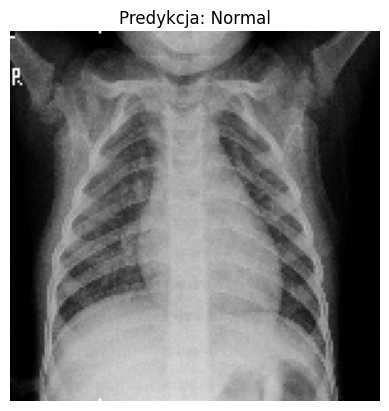

In [5]:
import keras
from keras import ops
from keras import utils
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt


# Ścieżka do wybranego obrazu z zestawu danych
sample_image_path = '/content/chest-xray-pneumonia/chest_xray/val/NORMAL/NORMAL2-IM-1436-0001.jpeg'  # zamień na faktyczną ścieżkę

# Wczytanie obrazu i przeskalowanie do wymiarów modelu
sample_img = keras.utils.load_img(sample_image_path, target_size=(img_width, img_height))
sample_img_array = keras.utils.img_to_array(sample_img)
sample_img_array = np.expand_dims(sample_img_array, axis=0)
sample_img_array /= 255.0

# Predykcja dla wybranego obrazu
prediction = model.predict(sample_img_array)[0][0]
print( model.predict(sample_img_array))
print(prediction)
print("Predykcja (prawdopodobieństwo Pneumonii):", prediction)
if prediction > 0.5:
    print("Wynik: Pneumonia")
else:
    print("Wynik: Normal")

# Wyświetlenie obrazu wraz z wynikową predykcją
plt.imshow(sample_img)
plt.title("Predykcja: " + ("Pneumonia" if prediction > 0.5 else "Normal"))
plt.axis('off')
plt.show()

In [6]:
!zip -q -r 'pneumonia_classification_model.zip' 'pneumonia_classification_model'

In [10]:
import tempfile

MODEL_DIR = '/content/model/'#tempfile.gettempdir()
MODEL_NAME = 'pneumonia_classification_model'
version = 1
export_path = os.path.join(MODEL_DIR, MODEL_NAME, str(version))
print('export_path = {}\n'.format(export_path))

# Use tf.saved_model.save to export a SavedModel
tf.saved_model.save(
    model,
    export_path
)

print('\nSaved model:')
!ls -l {export_path}

export_path = /content/model/pneumonia_classification_model/1


Saved model:
total 124
drwxr-xr-x 2 root root   4096 Feb 17 15:22 assets
-rw-r--r-- 1 root root     56 Feb 17 15:22 fingerprint.pb
-rw-r--r-- 1 root root 113465 Feb 17 15:22 saved_model.pb
drwxr-xr-x 2 root root   4096 Feb 17 15:22 variables
